In [90]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()

In [91]:
data = pd.read_csv(r"C:\Users\91963\OneDrive\Documents\Retail.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})
data.shape

(541910, 8)

# 2. Get familiar with the data

In [92]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


# 3. Get an initial feeling for the data by exploration 

In [93]:
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

Invoice         0.000000
StockCode       0.000000
Description     0.268310
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
CustomerID     24.926648
Country         0.000000
dtype: float64

Almost 25 % of the customers are unknown! That's very strange. In addition we have 0.2 % of missing descriptions. This looks dirty. Let's gain a further impression by considering some examples.

**Missing descriptions**

In [94]:
data[data.Description.isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1510,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1985,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1986,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
2022,536552,20950,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


How often do we miss the customer as well?


In [95]:
data[data.Description.isnull()].CustomerID.isnull().value_counts()

True    1454
Name: CustomerID, dtype: int64

And the unit price?


In [96]:
data[data.Description.isnull()].Price.value_counts()

0.0    1454
Name: Price, dtype: int64

In **cases of missing descriptions we always miss the customer and the unit price as well**. Why does the retailer records such kind of entries without a further description? It seems that there is no sophisticated procedure how to deal with and record such kind of transactions. This is already a hint that **we could expect strange entries in our data and that it can be difficult to detect them**! 


**Missing Customer IDs**


In [97]:
data[data.CustomerID.isnull()].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [98]:
data.loc[data.CustomerID.isnull(),["Quantity",'Price']].describe()

,Quantity,Price
count,135080.000000,135080.000000
mean,1.995573,8.076577
std,66.696153,151.900816
min,-9600.000000,-11062.060000
25%,1.000000,1.630000
50%,1.000000,3.290000
75%,3.000000,5.450000
max,5568.000000,17836.460000


Here also we can see The price and the quantities of entries without a customer ID can show extreme outliers.And the question remains: Why is it possible for a transaction to be without a customer ID. Perhaps you can purchase as a quest but then it would of a good and clean style to plugin a special ID that indicates that this one is a guest. Ok, next one: Do we have hidden nan-values in Descriptions? To find it out, let's create a new feature that hold descriptions in lowercase:

In [99]:
data.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
CustomerID     135080
Country             0
dtype: int64

In [100]:
data.dropna(inplace=True)

To chech if it contains Empty string

In [101]:
data.Description.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

False    406830
Name: Description, dtype: int64

In [102]:
data.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

Invoice  StockCode  Description  Quantity  InvoiceDate  Price  CustomerID  Country
False    False      False        False     False        False  False       False      406830
dtype: int64

In [103]:
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
dtype: int64

**No null Values found**

# The Time period 
How long is the period in days?

In [104]:
data['InvoiceDate']=pd.to_datetime(data.InvoiceDate)

data.InvoiceDate.max() - data.InvoiceDate.min()


Timedelta('373 days 04:24:00')

In [105]:
print("Datafile starts with timepoint {}".format(data.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(data.InvoiceDate.max()))

Datafile starts with timepoint 2010-12-01 08:26:00
Datafile ends with timepoint 2011-12-09 12:50:00


# The Invoice Number

How many different invoice numbers do we have?


In [106]:
data.Invoice.nunique()

22190

In [107]:
data["IsCancelled"]=np.where(data.Invoice.apply(lambda l: l[0]=="C"), True, False)
data.IsCancelled.value_counts() / data.shape[0] * 100

False    97.811125
True      2.188875
Name: IsCancelled, dtype: float64

2.2 % of all entries are cancellations.  


In the data description we can find that a cancelled transactions starts with a "C" in front of it. Let's create a feature to easily filter out these cases:

In [110]:
data.loc[data.IsCancelled==True].describe()

,Quantity,Price
count,8905.000000,8905.000000
mean,-30.859966,18.845519
std,1170.154939,444.366043
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


**All cancellations have negative quantites but positive, non-zero unit prices**. Given this data we are not easily able to understand why a customer made a return and it's very difficult to predict such cases as there could be several, hidden reasons why a cancellation was done. Let's drop them:

In [113]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France


# Stockcodes 

In [114]:
data.StockCode.nunique()


3665

Which codes are most common?


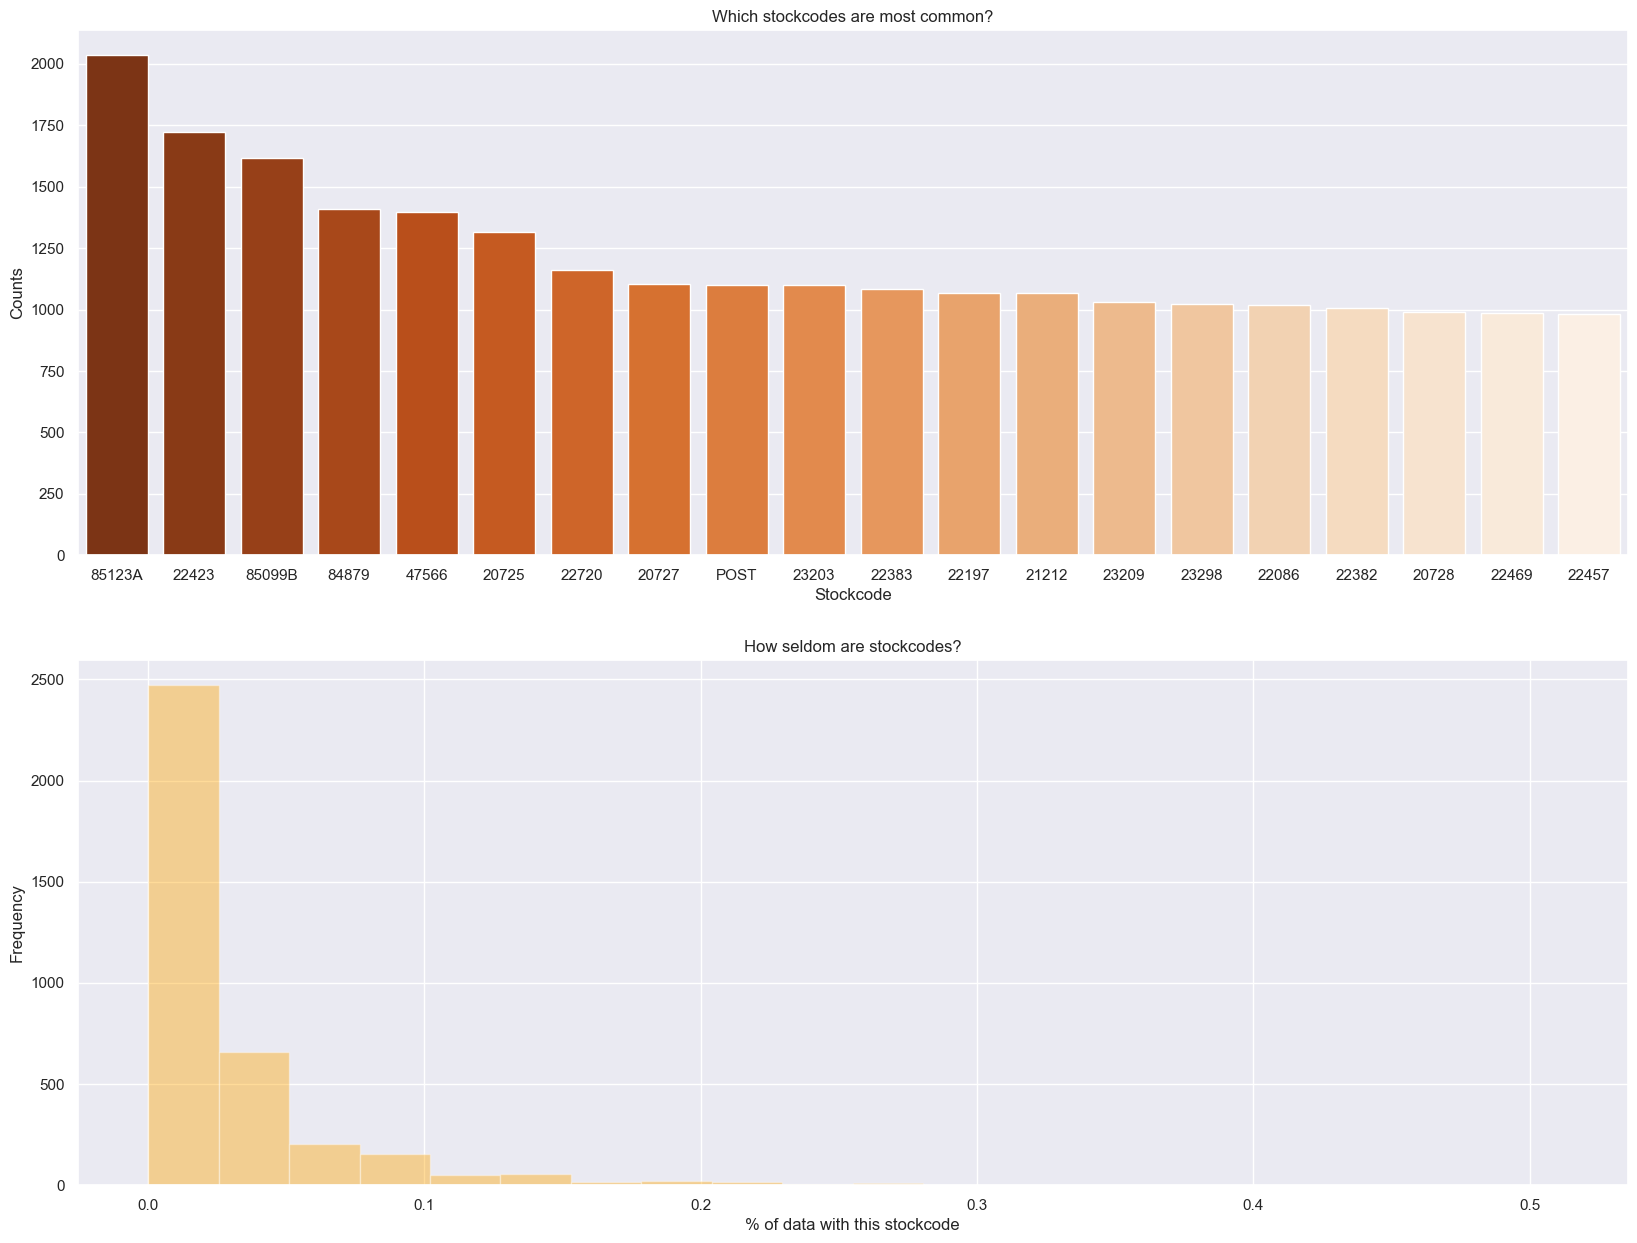

In [115]:
stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(stockcode_counts.iloc[0:20].index,
            stockcode_counts.iloc[0:20].values,
            ax = ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

* Do you the the **POST** in the most common stockcode counts?! **That's a strange one!** Hence we could expect strange occurences not only in the descriptions and customerIDs but also in the stockcode.It's code is shorter than the others as well as not numeric. 
* Most stockcodes are very seldom. This indicates that the **retailer sells many different products** and that there is no strong secialization of a specific stockcode. Nevertheless we have to be careful as this must not mean that the retailer is not specialized given a specific product type. The stockcode could be a very detailed indicator that does not yield information of the type, for example water bottles may have very different variants in color, name and shapes but they are all water bottles.  

# Descriptions

How many unique descriptions do we have?

In [117]:
data.Description.nunique()

3877

And which are the most common

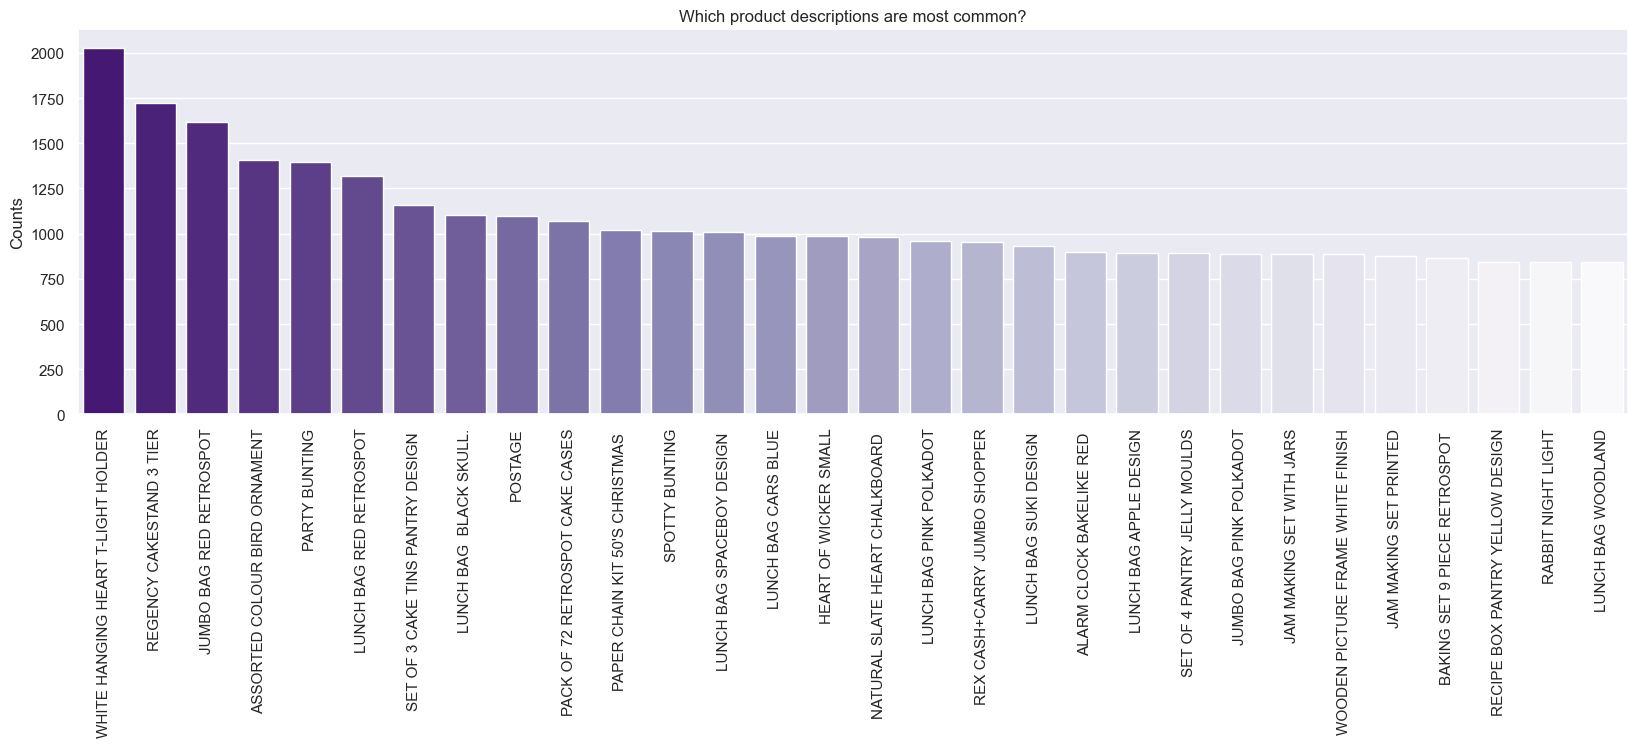

In [121]:
description_counts = data.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90);

Ok, we can see that **some descriptions correspond to a similar product type**. Do you see the multiple occurences of lunch bags? We often have **color information about the product** as well. Furthermore the most common descriptions seem to confirm that **the retailer sells various different kinds of products**. All descriptions seem to consist of **uppercase chars**. Ok, now let's do some addtional analysis on the descriptions by counting the length and the number of lowercase chars. 

# Customers

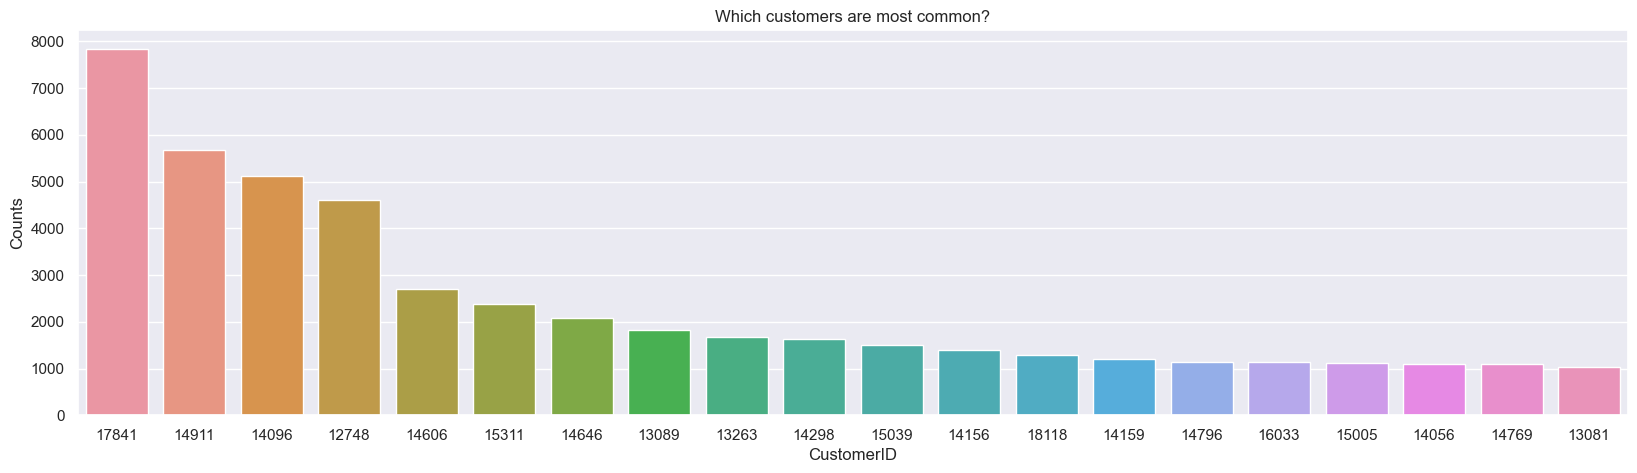

In [122]:
customer_counts = data.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);

# Countries
How many unique countries are delivered by the retailer?

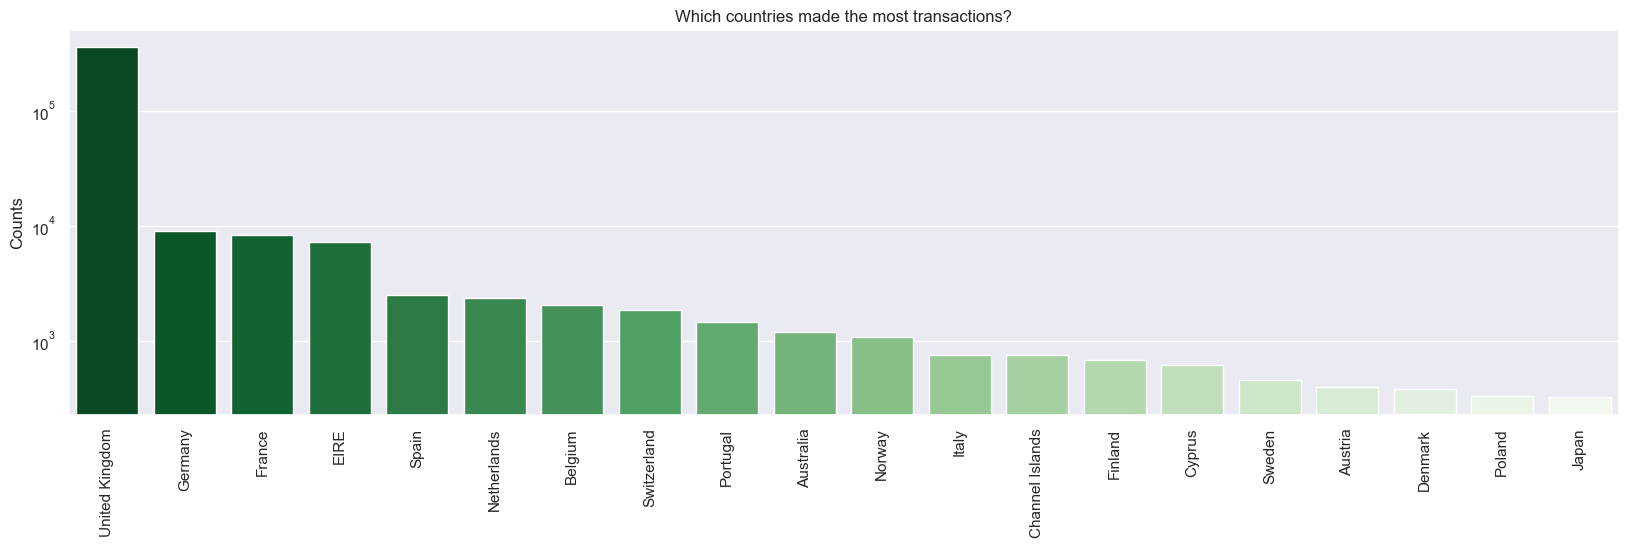

In [123]:
country_counts = data.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values, palette="Greens_r")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

United Kingdom has the max count

# Unit Price

In [125]:
data.Price.describe()

count    397925.000000
mean          3.116212
std          22.096773
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: Price, dtype: float64